In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
import mlflow
import mlflow.sklearn


In [3]:
features_df = pd.read_csv('../data/processed/features.csv')

In [4]:
from sklearn.preprocessing import LabelEncoder
X = features_df.drop('label', axis=1).values  # features
y = features_df['label'].values  # target variable
le = LabelEncoder()
y = le.fit_transform(y)
X.shape, y.shape

((17579, 24), (17579,))

In [5]:
# Define the pipeline that includes scaling and the classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

# Parameters to search
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf']
}

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='accuracy')

# MLflow experiment setup
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("ECG_Heart_Rhythm_Classification_SVM")

# Start MLflow run
with mlflow.start_run(run_name="SVM"):
    # Execute the grid search
    grid_search.fit(X, y)

    # Best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Perform KFold cross-validation
    cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='accuracy')
    
    # Log parameters and metrics
    mlflow.log_params(best_params)
    mlflow.log_metric("cv_accuracy_mean", cv_scores.mean())
    mlflow.log_metric("cv_accuracy_std", cv_scores.std())
    
    # Log the best model
    mlflow.sklearn.log_model(best_model, "model")

    print(f"Best Parameters: {best_params}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


2024/02/28 21:01:00 INFO mlflow.tracking.fluent: Experiment with name 'ECG_Heart_Rhythm_Classification_SVM' does not exist. Creating a new experiment.


Best Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
CV Accuracy: 0.7631 (+/- 0.0067)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Fit the best model on the training set
best_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=10, probability=True))])

In [11]:
# Predict the test set
y_pred = best_model.predict(X_test)

In [12]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7676


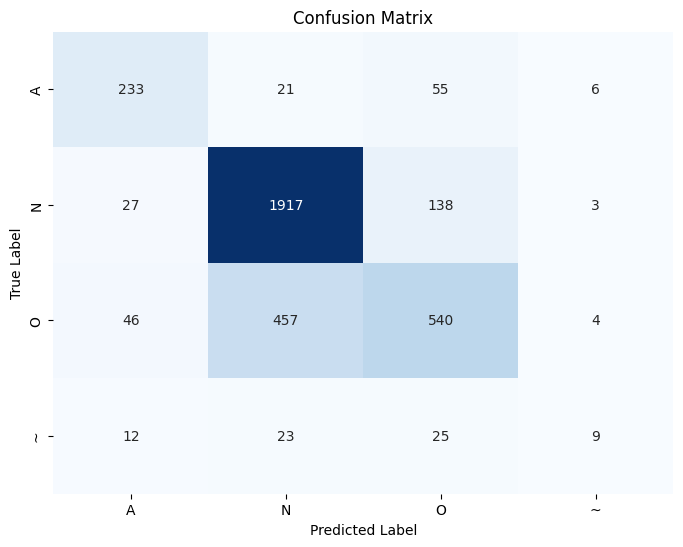

In [13]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

           A       0.73      0.74      0.74       315
           N       0.79      0.92      0.85      2085
           O       0.71      0.52      0.60      1047
           ~       0.41      0.13      0.20        69

    accuracy                           0.77      3516
   macro avg       0.66      0.58      0.60      3516
weighted avg       0.76      0.77      0.75      3516



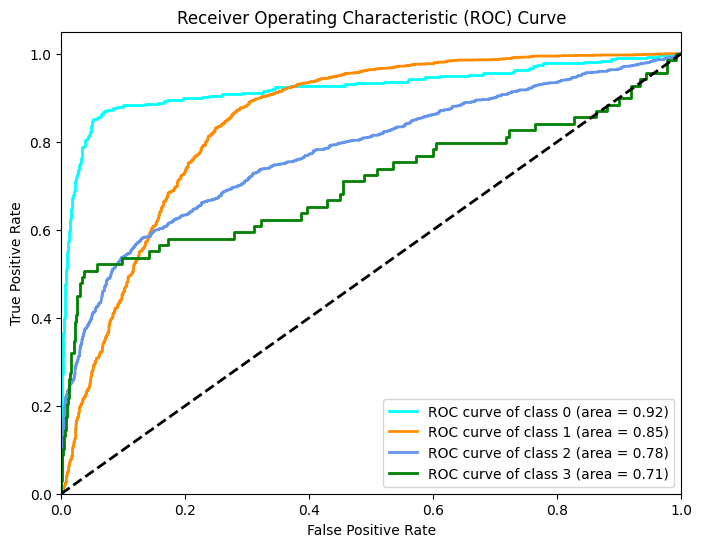

In [16]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output for the entire dataset before train-test split
y = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming best_model is a model instance from GridSearchCV or similar
classifier = OneVsRestClassifier(best_model)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

mlflow.end_run()
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("ECG_Heart_Rhythm_Classification")
with mlflow.start_run(run_name="SVM"):
    for i in range(n_classes):
        mlflow.log_metric(f"roc_auc_class_{i}", roc_auc[i])
        
    # Calculate and log the mean ROC AUC
    mean_roc_auc = np.mean(list(roc_auc.values()))
    mlflow.log_metric("mean_roc_auc", mean_roc_auc)

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
    label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


- Class 0 (Atrial Fibrillation): AUC of 0.92, slightly lower than Logistic Regression, but still showing excellent performance.
- Class 1 (Normal): AUC of 0.85, which is higher than Logistic Regression, indicating better performance for the Normal class.
- Class 2 (Other Rhythms): AUC remains the same at 0.78, indicating no significant change in performance for this class.
- Class 3 (Noise): AUC of 0.71, a decrease from Logistic Regression, suggesting SVM may be less effective at distinguishing noisy signals.

Comparison:

The SVM model shows an improved ability to classify Normal rhythms compared to the Logistic Regression model, as evidenced by a higher AUC. However, for the Atrial Fibrillation class and Noisy signals, the Logistic Regression model appears to outperform the SVM, as indicated by higher AUC values. The performance on the Other Rhythms class is comparable between the two models.

In summary, the choice between using Logistic Regression or SVM may depend on which classes are more critical to distinguish accurately. If the priority is to detect Atrial Fibrillation and Noise effectively, Logistic Regression could be preferable. However, if the focus is on correctly identifying Normal rhythms, the SVM might be the better model. The performance on the Other Rhythms class does not significantly influence the choice between the two models.

Conclusion:

The SVM model outperforms the Logistic Regression model across all classes except for noisy recordings, where both models exhibit challenges. The higher overall accuracy and F1-scores for the SVM model indicate that it is generally better at classifying heart rhythms for this dataset. The improvement is particularly noticeable in the Atrial Fibrillation and Other Rhythms classes, which are critical for a robust ECG classification system.

Both models could potentially benefit from further tuning, additional feature engineering, or even ensemble methods to improve performance, especially in the recall for Other Rhythms and the precision and recall for Noise. Given the clinical importance of accurate heart rhythm classification, it is essential to consider these metrics in the context of their impact on patient outcomes and diagnosis.